In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime as dt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from math import sqrt

In [2]:
data = pd.read_csv('../data/Arizona19NO2.csv', encoding='utf8', engine='python')
data = data.drop(data.columns[0], axis=1)

                   
date = pd.to_datetime(data['Date Local'])
data['Date Local'] = date

data2000 = data.loc[data['Date Local'].dt.year == 2000]
data2001 = data.loc[data['Date Local'].dt.year == 2001]
date2000 = []
date2001 = []

for i in data2000['Date Local']:
    #print(dt.datetime.strptime(i, '%Y-%m-%d').strftime('%m-%d'))
    date2000.append(dt.datetime.strptime(str(i), '%Y-%m-%d %H:%M:%S').strftime('%m-%d'))
    
for i in data2001['Date Local']:
    #print(dt.datetime.strptime(i, '%Y-%m-%d').strftime('%m-%d'))
    date2001.append(dt.datetime.strptime(str(i), '%Y-%m-%d %H:%M:%S').strftime('%m-%d'))
    
data2000['Date Local'] = pd.to_datetime(date2000, format='%m-%d')
data2001['Date Local'] = pd.to_datetime(date2001, format='%m-%d')
ts2000 = data2000.set_index('Date Local')
ts2001 = data2001.set_index('Date Local')
print(ts2000.head())

             NO2 Mean
Date Local           
1900-01-01  15.208333
1900-01-02  18.500000
1900-01-04  31.521739
1900-01-05  28.541667
1900-01-06  27.250000


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Plot for seasonality in 2000 vs 2001

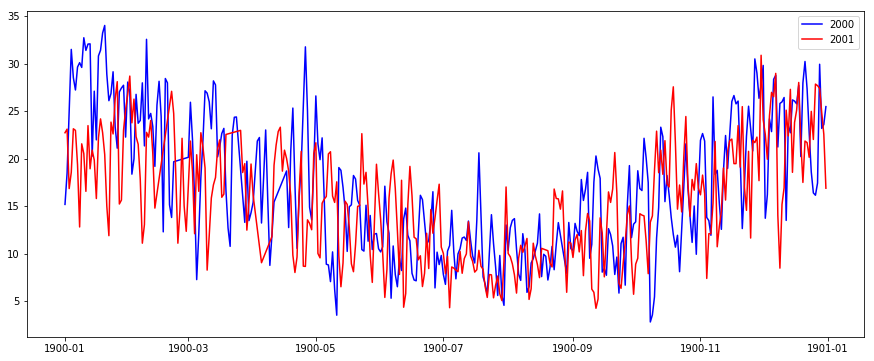

In [3]:
plt2000 = plt.plot(ts2000, color='blue',label='2000')
plt2001 = plt.plot(ts2001, color='red', label='2001')

plt.legend(loc='best')
plt.title('')
plt.show(block=False)

#### Euclidean vs Dynamic Time Warping

In [4]:
def DynamicTimeWarping(ts1, ts2, window):
    DTW_Dictionary={}
    
    window = max(window, abs(len(ts1)-len(ts2)))
    
    for i in range(-1,len(ts1)):
        for j in range(-1,len(ts2)):
            DTW_Dictionary[(i, j)] = float('inf')
    DTW_Dictionary[(-1, -1)] = 0
    i=0
    for m in ts1.index:
        j=max(0,i-window)
        for n in ts2.index:
            distance = (ts1.loc[m]['NO2 Mean']-ts2.loc[n]['NO2 Mean'])**2
            DTW_Dictionary[(i, j)] = distance + min(DTW_Dictionary[(i-1, j)],DTW_Dictionary[(i, j-1)], DTW_Dictionary[(i-1, j-1)])
            j=j+1
            if(j==min(len(ts2),i+window)):
                break
        i=i+1
    return np.sqrt(DTW_Dictionary[len(ts1)-1, len(ts2)-1])

In [6]:
print(DynamicTimeWarping(ts2000,ts2001,10))

73.2240440359


In [14]:
def euclid_dist(t1,t2):
    return sqrt(sum((t1-t2)**2))

print(euclid_dist(ts2000.values[0:340],ts2001.values[:340]))

125.0920131559344


In [7]:
def LB_Keogh(ts1,ts2,reach):
    LB_sum = 0
    ind=0
    for i in ts1.index:
        lower_bound = min(ts2[(ind-reach if ind-reach>=0 else 0):(ind+reach)]['NO2 Mean'])
        upper_bound = max(ts2[(ind-reach if ind-reach>=0 else 0):(ind+reach)]['NO2 Mean'])
        if ts1.loc[i]['NO2 Mean']>upper_bound:
            LB_sum = LB_sum+(ts1.loc[i]['NO2 Mean']-upper_bound)**2
        elif ts1.loc[i]['NO2 Mean']<lower_bound:
            LB_sum = LB_sum+(ts1.loc[i]['NO2 Mean']-lower_bound)**2
        ind=ind+1
    return np.sqrt(LB_sum)

In [8]:
print(LB_Keogh(ts2000,ts2001,10))

31.1687420531


In [138]:
from sklearn.metrics import classification_report
date2002=[]
data2002 = data.loc[data['Date Local'].dt.year == 2002]
for i in data2002['Date Local']:
    #print(dt.datetime.strptime(i, '%Y-%m-%d').strftime('%m-%d'))
    date2002.append(dt.datetime.strptime(str(i), '%Y-%m-%d %H:%M:%S').strftime('%m-%d'))
data2002['Date Local'] = pd.to_datetime(date2002, format='%m-%d')
ts2002 = data2000.set_index('Date Local')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [7]:
finalSeries = []

for i in range(2000,2017):
    filename = "../data/data"+str(i)
    for j in range(1,13):
        filename = filename + "month" + str(j) +".csv"
        data = pd.read_csv(filename, usecols=['NO2 Mean'])
        series = data['NO2 Mean'].tolist()
        seriesNP = np.asarray(series)
        finalSeries.append(seriesNP)
        filename = "../data/data"+str(i)
        
finalSeriesNP = np.asarray(finalSeries)